# `StableSpectralElements.jl` - 1D linear advection-diffusion example

In [1]:
using StableSpectralElements, OrdinaryDiffEq, Plots, Plots.PlotMeasures, TimerOutputs

## Define the physical problem

In [2]:
a = 1.0  # wave speed
b = 5.0e-2 # diffusion coefficient
L = 1.0  # domain length
T = 1.0  # end time for one period
CFL = 0.1

initial_data = InitialDataSine(1.0,2π)
conservation_law = LinearAdvectionDiffusionEquation(a,b)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters

In [3]:
M = 4
p = 4
form = StandardForm()
ode_algorithm = CarpenterKennedy2N54();

## Set up a `NodalTensor` scheme of degree `p` with `M` elements

In [4]:
reference_approximation = ReferenceApproximation(
    NodalTensor(p), Line())

mesh = uniform_periodic_mesh(reference_approximation, (0.0,L), M)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T),
     "results/advection_diffusion_1d/", overwrite=true, clear=true);

## Run the solver and print timer outputs

In [5]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T), PhysicalOperator())

h = L / (reference_approximation.N_p * spatial_discretization.N_e)
dt = CFL * h / a

reset_timer!()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, (0.0,T),  
        floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      6.37s /  50.0%           1.63GiB /  58.1%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 rhs        1.07k    3.18s  100.0%  2.98ms   0.95GiB  100.0%   931KiB
 ────────────────────────────────────────────────────────────────────


## Calculate the integral L<sup>2</sup> error norm

In [6]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)

L2 error:
6.988447007965235e-6


## Analyze conservation and energy dissipation

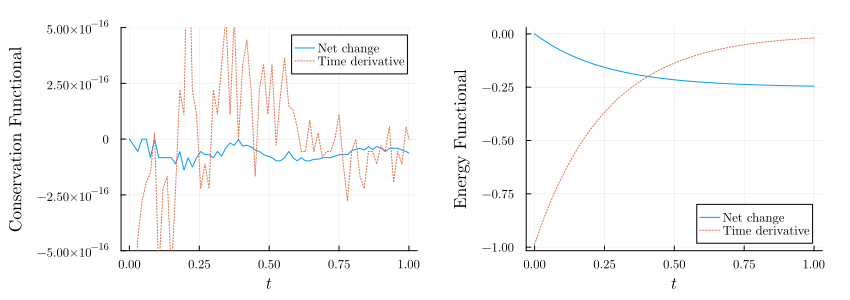

In [7]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Conservation Functional", ylims=[-5e-16, 5e-16])
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), 
    ylabel="Energy Functional", legend=:bottomright);
plot(p1,p2, size=(850,300),margin=5mm, fmt=:png)

## Plot the exact and numerical solutions

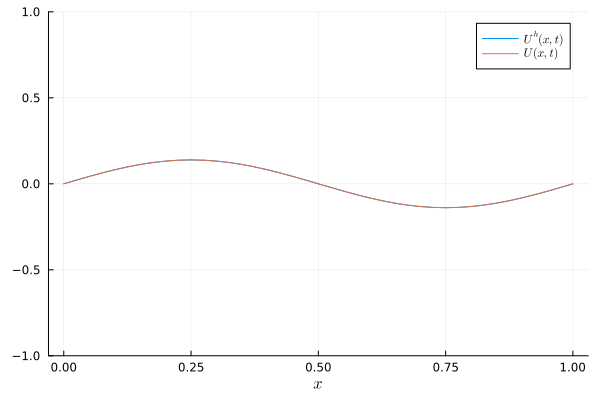

In [8]:
plot(spatial_discretization, last(sol.u), 
    exact_solution=exact_solution, time=T, ylims=[-1.0,1.0], fmt=:png)

## Animate the numerical solution

[ Info: Saved animation to /Users/tristanmontoya/Research/StableSpectralElements.jl/examples/advection_diffusion_solution.gif


Plots.AnimatedGif("/Users/tristanmontoya/Research/StableSpectralElements.jl/examples/advection_diffusion_solution.gif")
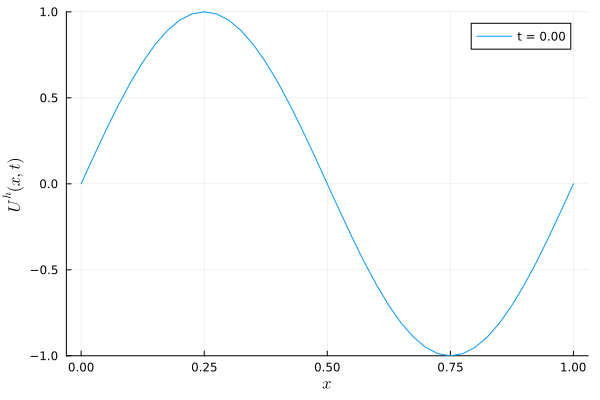

In [9]:
using Printf
anim = @animate for i ∈ eachindex(sol.u)
    plot(spatial_discretization, sol.u[i], 
        ylims=[-1.0,1.0], ylabel="\$U^h(x,t)\$",
        label=string("t = ", @sprintf "%.2f" sol.t[i]))
end
gif(anim, "advection_diffusion_solution.gif", fps = 10)